set lib

In [1]:
import os
import cv2
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import shutil
import warnings
import pandas as pd
import time
import random
import tensorflow as tf

WARNING:tensorflow:From c:\Users\noppa\anaconda3\envs\env\lib\site-packages\keras\src\losses.py:2976: The name tf.losses.sparse_softmax_cross_entropy is deprecated. Please use tf.compat.v1.losses.sparse_softmax_cross_entropy instead.

In [2]:
LOCAL_DATASET_PATH = "C:/Users/noppa/Desktop/I-NewGen/System/Project/images/subset"

In [3]:
dataset = pd.read_csv(os.path.join(LOCAL_DATASET_PATH, "dataset.csv"), index_col=[0])

In [4]:
print(dataset)

  person_id  age complexion genere observation         nir_image  \
0     M0001   11      obese      M         NaN  nir_images/0.png   
1     M0002   11     skinny      F         NaN  nir_images/1.png   
2     M0003   12       slim      F         NaN  nir_images/2.png   
3     M0004   12       slim      F         NaN  nir_images/3.png   
4     M0005   11     skinny      M         NaN  nir_images/4.png   
5     M0006   12       slim      M         NaN  nir_images/5.png   
6     M0007   11      obese      M         NaN  nir_images/6.png   
7     M0008   11     skinny      M         NaN  nir_images/7.png   
8     M0009   11       slim      M         NaN  nir_images/8.png   
9     M0010   11       slim      M    dwarfism  nir_images/9.png   

          preprocessed_image         mask  acf_bbox_x1  acf_bbox_x2  \
0  preprocessed_images/0.png  masks/0.png          779         1126   
1  preprocessed_images/1.png  masks/1.png          837         1080   
2  preprocessed_images/2.png  masks/2.

In [5]:
IMAGE_SIZE = 512
BATCH_SIZE = 4

In [6]:
TOTAL_SAMPLES = len(dataset)
print("Total samples:", TOTAL_SAMPLES)

Total samples: 10


In [7]:
NUM_TRAIN_SAMPLES = int(TOTAL_SAMPLES * 0.70)
NUM_VAL_SAMPLES = int(TOTAL_SAMPLES * 0.20)
NUM_TEST_SAMPLES = int(TOTAL_SAMPLES * 0.10)

In [8]:
print("Number of train images:",NUM_TRAIN_SAMPLES," val images:",NUM_VAL_SAMPLES," test images:",NUM_TEST_SAMPLES)

Number of train images: 7  val images: 2  test images: 1


In [9]:
def obtain_subset(dataset):
  images = [os.path.join(LOCAL_DATASET_PATH, image) for image in dataset["preprocessed_image"].values]
  masks = [os.path.join(LOCAL_DATASET_PATH, image) for image in dataset["mask"].values]
  x_centers = [ int(x) for x in dataset["acf_center_x"].values]
  y_centers = [ int(y) for y in dataset["acf_center_y"].values]
  angles = [ int(angle) for angle in dataset["arm_angle"].values]
  ids = [ int(id) for id in dataset.index]

  # Normalize angles and avoid similarity between 0 and 180
  for idx, angle in enumerate(angles):
    if angle > 170:
      angles[idx] = 0

  return images, masks, x_centers, y_centers, angles, ids

In [10]:
train_images, train_masks, train_acf_x_centers, train_acf_y_centers, train_angles, train_ids = obtain_subset(dataset[:NUM_TRAIN_SAMPLES])
val_images, val_masks, val_acf_x_centers, val_acf_y_centers, val_angles, val_ids = obtain_subset(dataset[NUM_TRAIN_SAMPLES : NUM_VAL_SAMPLES + NUM_TRAIN_SAMPLES])
test_images, test_masks, test_acf_x_centers, test_acf_y_centers, test_angles, test_ids = obtain_subset(dataset[NUM_VAL_SAMPLES + NUM_TRAIN_SAMPLES : ])

In [11]:
SAVED_MODEL = "C:/Users/noppa/Desktop/I-NewGen/System/Project/record/unet/best_model"

In [12]:
unet = tf.keras.models.load_model(SAVED_MODEL)

preprocessed_image: preprocessed_images/9.png


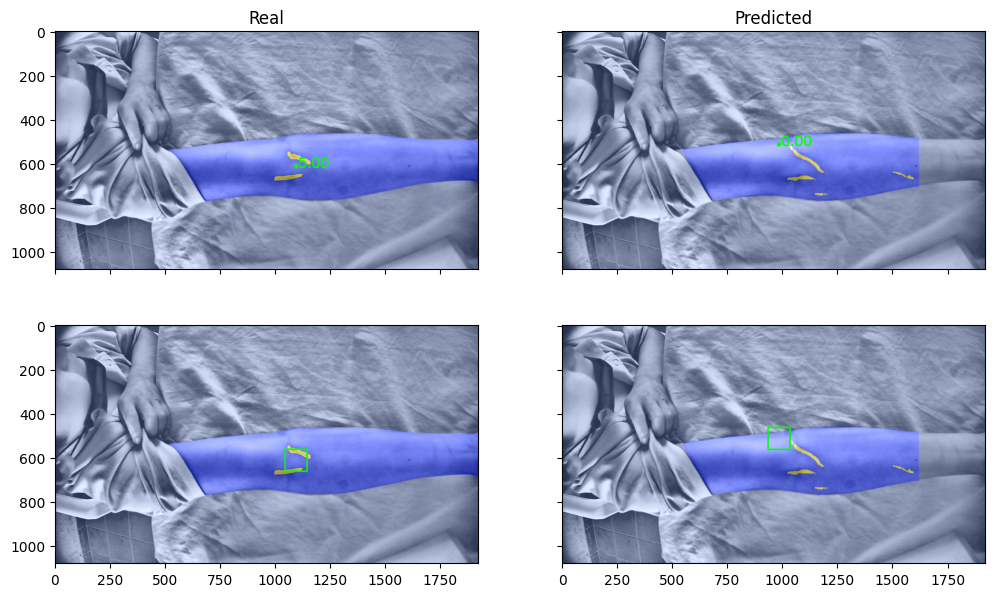

In [13]:
# Show visualization

def read_image(image_path, mask=False):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_png(image, channels=1)
  base_image = image
  image.set_shape([None, None, 1])
  if mask:
    image = tf.cast(image, dtype=tf.int32)
    return image
  else:
    image = tf.cast(image, dtype=tf.float32)
    image = image / 127.5 - 1
    return image, base_image

def normalize(image):
  image = image[:, 540:1620]
  image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
  return image

def infer(model, image_tensor):
  mask, values = model.predict(np.expand_dims((image_tensor), axis=0), verbose=0)
  mask = np.squeeze(mask)
  mask_npy = np.argmax(mask, axis=2).astype(np.uint8)
  mask = tf.convert_to_tensor(mask_npy)

  predictions = {
    "image": image_tensor,
    "mask": mask,
    "x": int(values[0][0] * 1080) + 420,
    "y": int(values[0][1] * 1080),
    "angle": values[0][2] * 180 if len(values[0]) > 2 else 0,  # แก้ไขเพื่อรองรับกรณีไม่มี angle
    "type": "predicted"
}


  return predictions


def plot_visualization(real_data, predicted_data):
  colors = {"background":[59, 82, 139],
            "arm":[3, 31, 254],
            "veins":[253, 231, 37]}

  visualization = []
  image = real_data["image"].numpy().astype(np.uint8)
  image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
  for data in [real_data,
               predicted_data
               ]:
    mask = data["mask"].numpy().astype(np.uint8)
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)

    mask[np.where((mask==[0,0,0]).all(axis=2))] = colors["background"]
    mask[np.where((mask==[1,1,1]).all(axis=2))] = colors["arm"]
    mask[np.where((mask==[2,2,2]).all(axis=2))] = colors["veins"]

    if data["type"] == "predicted":
      mask = cv2.resize(mask, (1080,1080), interpolation = cv2.INTER_AREA)
      final_mask = np.full(shape = (1080,1920,3), fill_value=colors["background"])
      final_mask[:,540:1620,:] = mask
      mask = final_mask.astype(np.uint8)

    new_image = cv2.addWeighted(image, 0.8, mask, 0.5, 0.0)
    angle = data["angle"]
    cv2.circle(new_image, (data["x"], data["y"]), radius=10, color=(0,255,0), thickness=-1)
    cv2.putText(new_image, f"{angle:.2f}", (data["x"]+10,data["y"]+5), cv2.FONT_HERSHEY_SIMPLEX , 2, (0,255,0), thickness = 5)
    visualization.append(new_image)

    # Preprocessing
    new_image2 = cv2.addWeighted(image, 0.8, mask, 0.5, 0.0)
    size = 100
    start_point = (data["x"]-int(size/2), data["y"]-int(size/2))
    end_point = (data["x"]+int(size/2), data["y"]+int(size/2))
    new_image2 = cv2.rectangle(new_image2, start_point, end_point, (0,255,0), 5)
    visualization.append(new_image2)
    cv2.imshow("Inference", cv2.cvtColor(new_image2, cv2.COLOR_BGR2RGB))
    cv2.waitKey(0)
    cv2.destroyAllWindows()


  f, ax = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(12, 7))

  ax[0][0].set_title("Real")
  ax[0][0].imshow(visualization[0])
  ax[0][1].set_title("Predicted")
  ax[0][1].imshow(visualization[2])
  ax[1][0].imshow(visualization[1])
  ax[1][1].imshow(visualization[3])

def make_prediction(model):
  random_sample = random.randint(0, len(test_images)-1)
  id = test_ids[random_sample]

  image = test_images[random_sample]
  image_tensor, base_image_tensor = read_image(image)

  mask = test_masks[random_sample]
  mask_tensor = read_image(mask, mask=True)
  real_data = {"image": base_image_tensor,
               "mask": mask_tensor,
               "x":test_acf_x_centers[random_sample],
               "y":test_acf_y_centers[random_sample],
               "angle":test_angles[random_sample],
               "type":"real"}

  image_tensor = normalize(image_tensor)
  predicted_data = infer(model=model, image_tensor=image_tensor)
  plot_visualization(real_data, predicted_data)
  print("preprocessed_image:", dataset.at[id, "preprocessed_image"])

make_prediction(unet)

In [14]:
# Show visualization

def read_image(image_path, mask=False):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_png(image, channels=1)
  base_image = image
  image.set_shape([None, None, 1])
  if mask:
    image = tf.cast(image, dtype=tf.int32)
    return image
  else:
    image = tf.cast(image, dtype=tf.float32)
    image = image / 127.5 - 1
    return image, base_image

In [15]:
def normalize(image):
  image = image[:, 540:1620]
  image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
  return image

In [16]:
def infer(model, image_tensor):
  mask, values = model.predict(np.expand_dims((image_tensor), axis=0), verbose=0)
  mask = np.squeeze(mask)
  mask_npy = np.argmax(mask, axis=2).astype(np.uint8)
  mask = tf.convert_to_tensor(mask_npy)

  predictions = {
    "image": image_tensor,
    "mask": mask,
    "x": int(values[0][0] * 1080) + 420,
    "y": int(values[0][1] * 1080),
    "angle": values[0][2] * 180 if len(values[0]) > 2 else 0,  # แก้ไขเพื่อรองรับกรณีไม่มี angle
    "type": "predicted"
}


  return predictions

In [17]:
def plot_visualization(real_data, predicted_data):
  colors = {"background":[59, 82, 139],
            "arm":[3, 31, 254],
            "veins":[253, 231, 37]}

  visualization = []
  image = real_data["image"].numpy().astype(np.uint8)
  image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
  for data in [real_data,
               predicted_data
               ]:
    mask = data["mask"].numpy().astype(np.uint8)
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)

    mask[np.where((mask==[0,0,0]).all(axis=2))] = colors["background"]
    mask[np.where((mask==[1,1,1]).all(axis=2))] = colors["arm"]
    mask[np.where((mask==[2,2,2]).all(axis=2))] = colors["veins"]

    if data["type"] == "predicted":
      mask = cv2.resize(mask, (1080,1080), interpolation = cv2.INTER_AREA)
      final_mask = np.full(shape = (1080,1920,3), fill_value=colors["background"])
      final_mask[:,540:1620,:] = mask
      mask = final_mask.astype(np.uint8)

    new_image = cv2.addWeighted(image, 0.8, mask, 0.5, 0.0)
    angle = data["angle"]
    cv2.circle(new_image, (data["x"], data["y"]), radius=10, color=(0,255,0), thickness=-1)
    cv2.putText(new_image, f"{angle:.2f}", (data["x"]+10,data["y"]+5), cv2.FONT_HERSHEY_SIMPLEX , 2, (0,255,0), thickness = 5)
    visualization.append(new_image)

    # Preprocessing
    new_image2 = cv2.addWeighted(image, 0.8, mask, 0.5, 0.0)
    size = 100
    start_point = (data["x"]-int(size/2), data["y"]-int(size/2))
    end_point = (data["x"]+int(size/2), data["y"]+int(size/2))
    new_image2 = cv2.rectangle(new_image2, start_point, end_point, (0,255,0), 5)
    visualization.append(new_image2)
    cv2.imshow("Inference", cv2.cvtColor(new_image2, cv2.COLOR_BGR2RGB))
    cv2.waitKey(0)
    cv2.destroyAllWindows()


  f, ax = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(12, 7))

  ax[0][0].set_title("Real")
  ax[0][0].imshow(visualization[0])
  ax[0][1].set_title("Predicted")
  ax[0][1].imshow(visualization[2])
  ax[1][0].imshow(visualization[1])
  ax[1][1].imshow(visualization[3])

In [18]:
def make_prediction(model):
  random_sample = random.randint(0, len(test_images)-1)
  id = test_ids[random_sample]

  image = test_images[random_sample]
  image_tensor, base_image_tensor = read_image(image)

  mask = test_masks[random_sample]
  mask_tensor = read_image(mask, mask=True)
  real_data = {"image": base_image_tensor,
               "mask": mask_tensor,
               "x":test_acf_x_centers[random_sample],
               "y":test_acf_y_centers[random_sample],
               "angle":test_angles[random_sample],
               "type":"real"}

  image_tensor = normalize(image_tensor)
  predicted_data = infer(model=model, image_tensor=image_tensor)
  plot_visualization(real_data, predicted_data)
  print("preprocessed_image:", dataset.at[id, "preprocessed_image"])

preprocessed_image: preprocessed_images/9.png


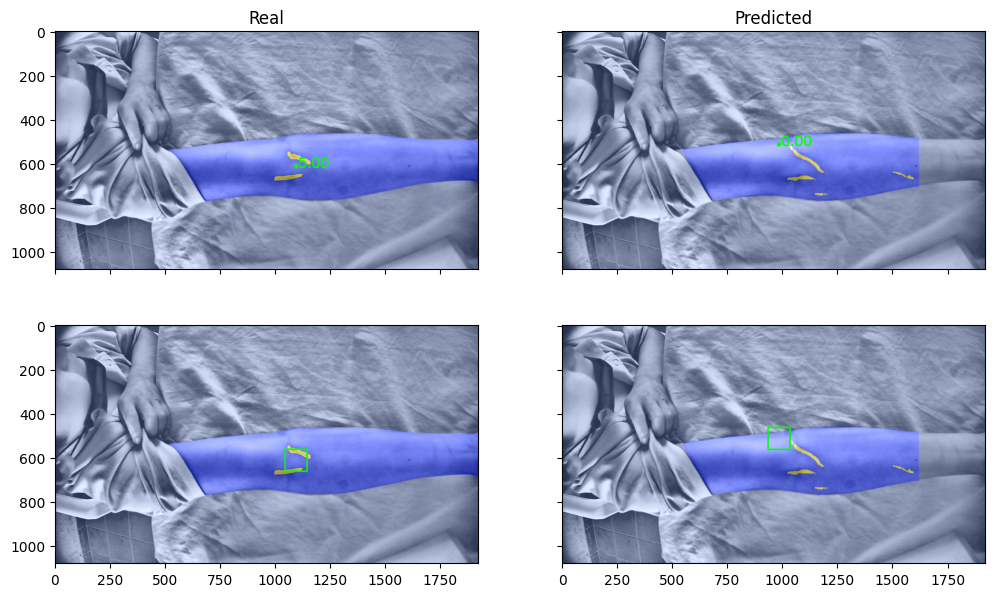

In [19]:
make_prediction(unet)